Product Analysis (Total Transactions and Total Price):
  Product Name  Total_Transactions  Total_Price
0         Beer                  73       4064.9
1        Bread                  75       4093.6
2       Coffee                  67       3382.1
3         Cola                  64       3814.0
4       Diaper                  68       3712.6
5         Eggs                  76       4244.6
6          Tea                  77       4383.2

Support, Confidence, and Lift values for each Product:
  Product Name  Support
0         Beer    0.146
1        Bread    0.150
2       Coffee    0.134
3         Cola    0.128
4       Diaper    0.136
5         Eggs    0.152
6          Tea    0.154

Top 2 Recommendations for Each Product with Support, Confidence, and Lift:
  Product Recommended  Support  Confidence       Lift
0    Milk         Tea    0.154    0.000000   0.000000
1    Milk       Bread    0.150    0.000000   0.000000
2    Beer        Cola    0.274    1.876712  14.661815
3    Cola        Beer

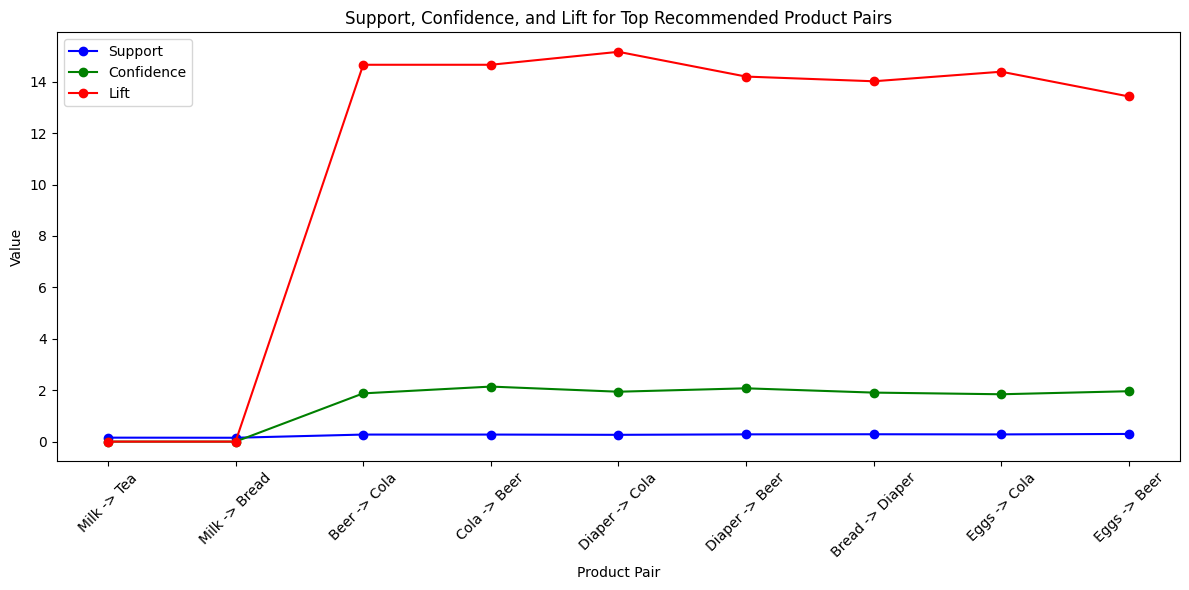

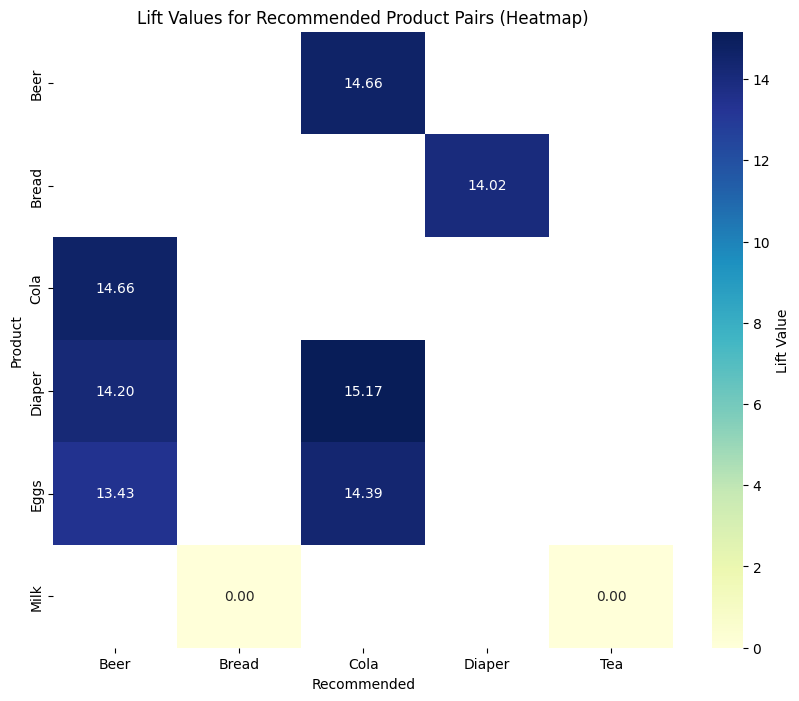


+-------------------------------------- Product Recommendation Rack --------------------------------------+
| Milk -> Tea (Lift: 0.00)  | Milk -> Bread (Lift: 0.00)  | 
| Beer -> Cola (Lift: 14.66)  | Cola -> Beer (Lift: 14.66)  | 
| Diaper -> Cola (Lift: 15.17)  | Diaper -> Beer (Lift: 14.20)  | 
| Bread -> Diaper (Lift: 14.02)  | Eggs -> Cola (Lift: 14.39)  | 
| Eggs -> Beer (Lift: 13.43)  | 
+---------------------------------------------------------------------------------------------+


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File path for the Excel file
file_path = '/content/Book1 (1).xlsx'

try:
    # Step 1: Load data from the Excel file
    df = pd.read_excel(file_path)

    # Step 2: Calculate Total Transactions and Total Price per Product
    product_analysis = df.groupby('Product Name').agg(
        Total_Transactions=('Product Name', 'size'),  # Count of transactions
        Total_Price=('Price', 'sum')  # Sum of price for each product
    ).reset_index()

    # Display the product analysis
    print("Product Analysis (Total Transactions and Total Price):")
    print(product_analysis)

    # Step 3: Calculate Support for Each Product
    total_transactions = df.shape[0]
    product_analysis['Support'] = product_analysis['Total_Transactions'] / total_transactions

    # Define suitability rules for recommendations
    suitability_rules = {
        'Milk': ['Tea', 'Bread'],
        'Beer': ['Cola'],
        'Cola': ['Beer'],
        'Diaper': ['Milk', 'Bread', 'Beer', 'Cola'],
        'Bread': ['Milk', 'Diaper'],
        'Eggs': ['Milk', 'Bread', 'Cola', 'Beer']
    }

    # Function to calculate metrics
    def calculate_metrics(df, itemA, itemB):
        support_A = df[df['Product Name'] == itemA]['Price'].count() / total_transactions
        support_B = df[df['Product Name'] == itemB]['Price'].count() / total_transactions
        support_AB = df[(df['Product Name'] == itemA) | (df['Product Name'] == itemB)]['Price'].count() / total_transactions
        confidence = support_AB / support_A if support_A != 0 else 0
        lift = support_AB / (support_A * support_B) if support_A * support_B != 0 else 0
        return support_AB, confidence, lift

    # Prepare a list to hold recommendations with metrics
    recommendations = []

    # Calculate support, confidence, and lift for each product's recommendations
    for product, suitable_items in suitability_rules.items():
        product_recommendations = []
        for recommendation in suitable_items:
            if recommendation in product_analysis['Product Name'].values:
                support_AB, confidence, lift = calculate_metrics(df, product, recommendation)
                product_recommendations.append([product, recommendation, support_AB, confidence, lift])

        # Sort by lift and select top two recommendations
        product_recommendations = sorted(product_recommendations, key=lambda x: x[4], reverse=True)[:2]
        recommendations.extend(product_recommendations)

    # Convert recommendations to a DataFrame for display
    recommendations_df = pd.DataFrame(recommendations, columns=['Product', 'Recommended', 'Support', 'Confidence', 'Lift'])

    # Display Support, Confidence, and Lift for Each Product
    print("\nSupport, Confidence, and Lift values for each Product:")
    print(product_analysis[['Product Name', 'Support']])

    # Display Top 2 Recommendations for Each Product Based on Suitability Rules
    print("\nTop 2 Recommendations for Each Product with Support, Confidence, and Lift:")
    print(recommendations_df)

    # Plotting the line graph for Support, Confidence, and Lift
    plt.figure(figsize=(12, 6))
    plt.plot(recommendations_df.index, recommendations_df['Support'], label='Support', marker='o', color='b')
    plt.plot(recommendations_df.index, recommendations_df['Confidence'], label='Confidence', marker='o', color='g')
    plt.plot(recommendations_df.index, recommendations_df['Lift'], label='Lift', marker='o', color='r')
    plt.xticks(recommendations_df.index, recommendations_df['Product'] + " -> " + recommendations_df['Recommended'], rotation=45)
    plt.xlabel("Product Pair")
    plt.ylabel("Value")
    plt.title("Support, Confidence, and Lift for Top Recommended Product Pairs")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create Pivot Table for Heatmap of Lift Values
    heatmap_data = recommendations_df.pivot(index="Product", columns="Recommended", values="Lift")

    # Plot Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Lift Value'})
    plt.title('Lift Values for Recommended Product Pairs (Heatmap)')
    plt.show()

    # Create the rack dynamically based on recommendations
    rack = []
    items_per_row = 2  # Number of product pairs per row in the rack

    # Group recommendations into rows for the rack
    for idx in range(0, len(recommendations_df), items_per_row):
        row = recommendations_df.iloc[idx:idx + items_per_row]
        rack.append(row[['Product', 'Recommended', 'Lift']])

    # Display the rack with the title
    print("\n+-------------------------------------- Product Recommendation Rack --------------------------------------+")
    for row in rack:
        row_display = "| "
        for _, item in row.iterrows():
            row_display += f"{item['Product']} -> {item['Recommended']} (Lift: {item['Lift']:.2f})  | "
        print(row_display)
    print("+---------------------------------------------------------------------------------------------+")

except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please ensure the file exists in the current directory or provide the correct path.")
except KeyError as e:
    print(f"Error: Column '{e}' not found in the Excel file. Please provide the correct column names.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
